The output of a tokenizer isn’t a simple Python dictionary; what we get is actually a special `BatchEncoding` object. It’s a subclass of a dictionary (which is why we were able to index into that result without any problem before), but with additional methods that are mostly used by fast tokenizers.

Besides their parallelization capabilities, the key functionality of fast tokenizers is that they always keep track of the original span of texts the final tokens come from — a feature we call ***offset mapping***. This in turn unlocks features like mapping each word to the tokens it generated or mapping each character of the original text to the token it’s inside, and vice versa.

In [1]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
encoding = tokenizer(example)
print(type(encoding))

<class 'transformers.tokenization_utils_base.BatchEncoding'>


In [2]:
tokenizer.is_fast

True

Let’s see what a fast tokenizer enables us to do. First, we can access the tokens without having to convert the IDs back to tokens:

In [4]:
print(encoding.tokens())

['[CLS]', 'My', 'name', 'is', 'S', '##yl', '##va', '##in', 'and', 'I', 'work', 'at', 'Hu', '##gging', 'Face', 'in', 'Brooklyn', '.', '[SEP]']


In this case the token at index 5 is `##yl`, which is part of the word “Sylvain” in the original sentence. We can also use the `word_ids()` method to get the index of the word each token comes from:

In [7]:
print(encoding.word_ids())

[None, 0, 1, 2, 3, 3, 3, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, None]


We can see that the tokenizer’s special tokens `[CLS]` and `[SEP]` are mapped to None, and then each token is mapped to the word it originates from. This is especially useful to determine if a token is at the start of a word or if two tokens are in the same word. We could rely on the `##` prefix for that, but it only works for BERT-like tokenizers; **this method works for any type of tokenizer** as long as it’s a fast one. In the next chapter, we’ll see how we can use this capability to ***apply the labels we have for each word*** properly to the tokens in tasks like named entity recognition (NER) and part-of-speech (POS) tagging. We can also use it to mask all the tokens coming from the same word in masked language modeling (a technique called **whole word masking**).

Similarly, there is a `sentence_ids()` method that we can use to map a token to the sentence it came from (though in this case, the `token_type_ids` returned by the tokenizer can give us the same information).

Lastly, we can map any word or token to characters in the original text, and vice versa, via the `word_to_chars()` or `token_to_chars()` and `char_to_word()` or `char_to_token()` methods. For instance, the `word_ids()` method told us that ##yl is part of the word at index 3, but which word is it in the sentence? We can find out like this:

In [12]:
encoding.token_type_ids

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [19]:
start, end = encoding.word_to_chars(3)
example[start:end]

'Sylvain'

# Inside the token-classification pipeline

https://www.youtube.com/watch?v=0E7ltQB7fM8

First, let’s grab a token classification pipeline so we can get some results to compare manually. The model used by default is `dbmdz/bert-large-cased-finetuned-conll03-english`; it performs NER on sentences:

In [ ]:
from transformers import pipeline

token_classifier = pipeline("token-classification")

In [25]:
res = token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")
for entity in res:
    print(entity)

{'entity': 'I-PER', 'score': 0.99938285, 'index': 4, 'word': 'S', 'start': 11, 'end': 12}
{'entity': 'I-PER', 'score': 0.99815494, 'index': 5, 'word': '##yl', 'start': 12, 'end': 14}
{'entity': 'I-PER', 'score': 0.99590707, 'index': 6, 'word': '##va', 'start': 14, 'end': 16}
{'entity': 'I-PER', 'score': 0.99923277, 'index': 7, 'word': '##in', 'start': 16, 'end': 18}
{'entity': 'I-ORG', 'score': 0.9738931, 'index': 12, 'word': 'Hu', 'start': 33, 'end': 35}
{'entity': 'I-ORG', 'score': 0.976115, 'index': 13, 'word': '##gging', 'start': 35, 'end': 40}
{'entity': 'I-ORG', 'score': 0.9887976, 'index': 14, 'word': 'Face', 'start': 41, 'end': 45}
{'entity': 'I-LOC', 'score': 0.9932106, 'index': 16, 'word': 'Brooklyn', 'start': 49, 'end': 57}


The model properly identified each token generated by “Sylvain” as a person, each token generated by “Hugging Face” as an organization, and the token “Brooklyn” as a location. We can also ask the pipeline to group together the tokens that correspond to the same entity:

In [ ]:
from transformers import pipeline

token_classifier = pipeline("token-classification", aggregation_strategy="simple")

In [27]:
res = token_classifier("My name is Sylvain and I work at Hugging Face in Brooklyn.")
for entity in res:
    print(entity)

{'entity_group': 'PER', 'score': 0.9981694, 'word': 'Sylvain', 'start': 11, 'end': 18}
{'entity_group': 'ORG', 'score': 0.9796019, 'word': 'Hugging Face', 'start': 33, 'end': 45}
{'entity_group': 'LOC', 'score': 0.9932106, 'word': 'Brooklyn', 'start': 49, 'end': 57}


The aggregation_strategy picked will change the scores computed for each grouped entity. With **`"simple"`** the score is just the mean of the scores of each token in the given entity: for instance, the score of “Sylvain” is the mean of the scores we saw in the previous example for the tokens `S`, `##yl`, `##va`, and `##in`. Other strategies available are:

- **`"first"`**, where the score of each entity is the score of the first token of that entity (so for “Sylvain” it would be 0.993828, the score of the token S)
- **`"max"`**, where the score of each entity is the maximum score of the tokens in that entity (so for “Hugging Face” it would be 0.98879766, the score of “Face”)
- **`"average"`**, where the score of each entity is the average of the scores of the words composing that entity (so for “Sylvain” there would be no difference from the "simple" strategy, but “Hugging Face” would have a score of 0.9819, the average of the scores for “Hugging”, 0.975, and “Face”, 0.98879)

Now let’s see how to obtain these results without using the `pipeline()` function!

## From inputs to predictions

First we need to tokenize our input and pass it through the model. This is done exactly by: instantiate the tokenizer and the model using the AutoXxx classes and then use them on our example:

In [ ]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

model_checkpoint = "dbmdz/bert-large-cased-finetuned-conll03-english"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)

example = "My name is Sylvain and I work at Hugging Face in Brooklyn."
inputs = tokenizer(example, return_tensors="pt")
outputs = model(**inputs)

Since we’re using `AutoModelForTokenClassification` here, we get one set of **logits for each token** in the input sequence:

In [30]:
print(f'inputs shape: {inputs["input_ids"].shape}')  # (batch_size, sequence_length)
print(f'outputs shape: {outputs.logits.shape}')  # (batch_size, sequence_length, num_labels)

inputs shape: torch.Size([1, 19])
outputs shape: torch.Size([1, 19, 9])


Like for the text classification pipeline, we use a softmax function to convert those logits to probabilities, and we take the **argmax to get predictions** (note that we can take the argmax on the logits because the softmax does not change the order):

In [31]:
import torch

probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)[0].tolist()
predictions = outputs.logits.argmax(dim=-1)[0].tolist()
print(predictions)

[0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 0, 6, 6, 6, 0, 8, 0, 0]


The `model.config.id2label` attribute contains the mapping of indexes to labels that we can use to make sense of the predictions:

In [35]:
model.config.id2label

{0: 'O',
 1: 'B-MISC',
 2: 'I-MISC',
 3: 'B-PER',
 4: 'I-PER',
 5: 'B-ORG',
 6: 'I-ORG',
 7: 'B-LOC',
 8: 'I-LOC'}

As we saw earlier, there are 9 labels: `O` is the label for the tokens that are not in any named entity (it stands for “outside”), and we then have two labels for each type of entity (**miscellaneous, person, organization, and location**). The label `B-XXX` indicates the token is at the beginning of an entity XXX and the label `I-XXX` indicates the token is inside the entity XXX. For instance, in the current example we would expect our model to classify the token S as B-PER (beginning of a person entity) and the tokens ##yl, ##va and ##in as I-PER (inside a person entity).

You might think the model was wrong in this case as it gave the label I-PER to all four of these tokens, but that’s not entirely true. There are actually two formats for those B- and I- labels: **IOB1 and IOB2**. The IOB2 format (in pink below), is the one we introduced whereas in the IOB1 format (in blue), the **labels beginning with B- are only ever used to separate two adjacent entities of the same type**. The model we are using was fine-tuned on a dataset using that format, which is why it assigns the label I-PER to the S token.

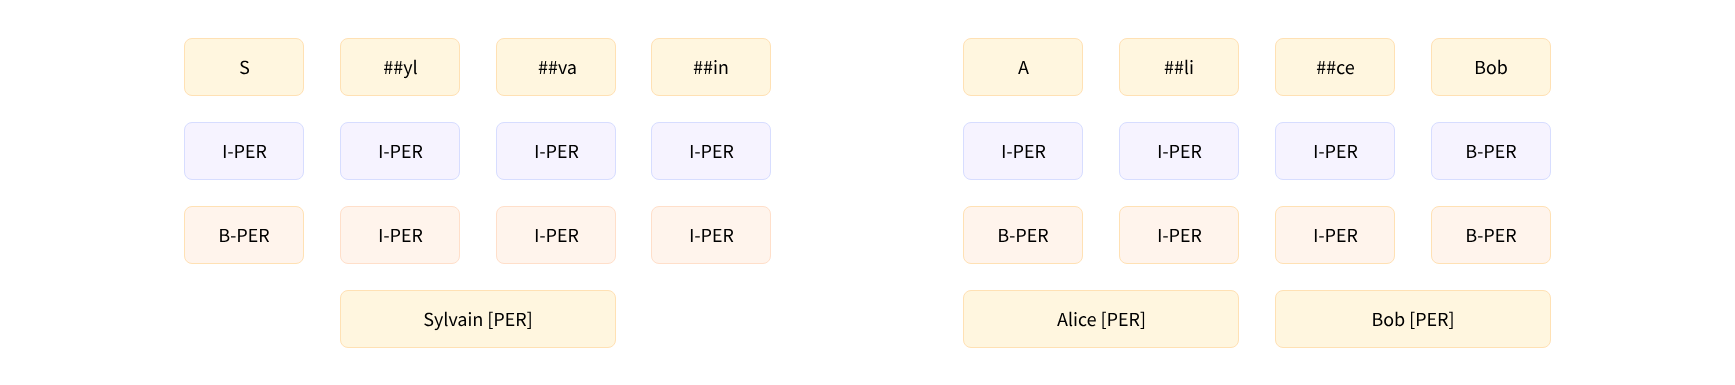

With this map (second approach, blue), we are ready to reproduce (almost entirely) the results of the first pipeline — we can just grab the score and label of each token that was not classified as `O`.

The pipeline also gave us **information about the start and end of each entity in the original sentence**. This is where our offset mapping will come into play. To get the **offsets**, we just have to set `return_offsets_mapping=True` when we apply the tokenizer to our inputs. Each tuple is the span of text corresponding to each token, where (0, 0) is reserved for the special tokens.

In [38]:
results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

for idx, pred in enumerate(predictions):  # Iterate over each token
    label = model.config.id2label[pred]  # Get the predicted label
    if label != "O":  # If it's not an 'Outside' entity, save it
        start, end = offsets[idx]  # Start-end offsets of the current token
        results.append(
            {
                "entity": label,
                "score": probabilities[idx][pred],
                "word": tokens[idx],
                "start": start,
                "end": end,
            }
        )

for entity in results:
    print(entity)

{'entity': 'I-PER', 'score': 0.9993828535079956, 'word': 'S', 'start': 11, 'end': 12}
{'entity': 'I-PER', 'score': 0.9981548190116882, 'word': '##yl', 'start': 12, 'end': 14}
{'entity': 'I-PER', 'score': 0.995907187461853, 'word': '##va', 'start': 14, 'end': 16}
{'entity': 'I-PER', 'score': 0.9992327690124512, 'word': '##in', 'start': 16, 'end': 18}
{'entity': 'I-ORG', 'score': 0.9738931059837341, 'word': 'Hu', 'start': 33, 'end': 35}
{'entity': 'I-ORG', 'score': 0.9761149883270264, 'word': '##gging', 'start': 35, 'end': 40}
{'entity': 'I-ORG', 'score': 0.9887974858283997, 'word': 'Face', 'start': 41, 'end': 45}
{'entity': 'I-LOC', 'score': 0.99321049451828, 'word': 'Brooklyn', 'start': 49, 'end': 57}


## Grouping entities

To write the code that post-processes the predictions while grouping entities, we will group together entities that are consecutive and labeled with `I-XXX`, except for the first one, which can be labeled as `B-XXX` or `I-XXX` (so, we stop grouping an entity when we get a `O`, a new type of entity, or a `B-XXX` that tells us an entity of the same type is starting):

In [39]:
import numpy as np

In [42]:
results = []
inputs_with_offsets = tokenizer(example, return_offsets_mapping=True)
tokens = inputs_with_offsets.tokens()
offsets = inputs_with_offsets["offset_mapping"]

idx = 0
while idx < len(predictions):  # Iterate over each token
    pred = predictions[idx]  # Get the predicted label
    label = model.config.id2label[pred]  # Get the predicted label name
    if label != "O":  # If the label is 'Outside', we are not interested
        # We will iterate here over all the tokens that correspond to the same entity
        # so we can safely take the label of the first token
        label = label[2:]  # Remove the B- or I-
        start, _ = offsets[idx]  # Take the start and look for the end next

        # Grab all the tokens labeled with I-label
        all_scores = []
        while (  # Iterate while we are in the same entity (the token is labeled I-{label})
            # Make sure we are not out of index
            idx < len(predictions)
            # Check that itered token is part of the SAME entity, consecutive (Inside-{label})
            and model.config.id2label[predictions[idx]] == f"I-{label}"
        ):
            all_scores.append(probabilities[idx][pred])  # Grab the score
            _, end = offsets[idx]  # Take the end offset (this will get update if more tokens)
            idx += 1  # Move the index to the next token

        # The score is the mean of all the scores of the tokens in that grouped entity
        score = np.mean(all_scores).item() 
        word = example[start:end]
        results.append(
            {
                "entity_group": label,
                "score": score,
                "word": word,
                "start": start,
                "end": end,
            }
        )
    idx += 1

for entity in results:
    print(entity)

{'entity_group': 'PER', 'score': 0.998169407248497, 'word': 'Sylvain', 'start': 11, 'end': 18}
{'entity_group': 'ORG', 'score': 0.9796018600463867, 'word': 'Hugging Face', 'start': 33, 'end': 45}
{'entity_group': 'LOC', 'score': 0.99321049451828, 'word': 'Brooklyn', 'start': 49, 'end': 57}
